In [1]:
# %load /home/shleifer/durbango/imports.py
#IMPORTS at top of notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

ISO = "ISO-8859-1"

import os
import pickle
from tqdm import tqdm, tqdm_notebook, tnrange
import numpy as np
import pandas as pd
import sys
from sklearn.metrics import *
import itertools
from collections import *
import funcy
from scipy.spatial.distance import cosine as cosine_distance
import matplotlib.pyplot as plt
from sklearn.linear_model import *
from sklearn.model_selection import StratifiedKFold, KFold, ParameterGrid
from sklearn.utils import shuffle
from numpy.testing import assert_array_equal
from sklearn.preprocessing import StandardScaler, RobustScaler
from pathlib import Path
import re
from glob import glob
import pickle
import socket
import torch
from torch import nn
import torch.nn.functional as F
from IPython.lib.display import FileLink

from durbango import *

HOSTNAME = socket.gethostname()
mock_arr = np.array(range(25)).reshape(5,5)
mock_df = pd.DataFrame(np.ones((5,5)), columns=['a', 'b', 'c', 'd', 'e'])
mock_df['color'] = ['red', 'blue', 'red', 'blue', 'green']
mock_df['bool_col'] = [True, False, True, False, True]
np.set_printoptions(precision=5, linewidth=110, suppress=True)

from ipykernel.kernelapp import IPKernelApp
from IPython.display import Markdown, display, HTML
from IPython.core.interactiveshell import InteractiveShell
def in_notebook(): return IPKernelApp.initialized()
def printmd(string): display(Markdown(string))
import warnings

display(HTML("<style>.container { width:90% !important; }</style>"))

# pretty print only the last output of the cell
# InteractiveShell.ast_node_interactivity = "last_expr" # "all" for all
try:
    with warnings.catch_warnings():
        import eli5
        from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
        import seaborn as sns
        from PIL import Image
except ImportError:
    pass


Path.ls =  lambda self: sorted(list(self.iterdir()))
ParameterGrid.l = property(lambda self: list(self))
pd.Series.flipped_dict = property(lambda ser: funcy.flip(ser.to_dict()))

pd.DataFrame.dsort = descending_sort
pd.Series.dsort = descending_sort
pd.DataFrame.asort = ascending_sort
pd.Series.asort = ascending_sort

%alias_magic h history -p "-l 20 -u -g"
pd.set_option('display.max_rows', 100)

Created `%h` as an alias for `%history -l 20 -u -g`.


In [3]:
#FOLD 
import datetime
import pytz
d = 'cheaper-metric-fixed'
def get_modtime(path):
    timestamp = os.path.getmtime(path)
    dt_object = datetime.datetime.fromtimestamp(timestamp)
    dt_object = dt_object.astimezone(pytz.timezone("America/Los_Angeles"))
    
    return dt_object.strftime('%m-%d-%H:%M')
    return str(dt_object)

def es_score(d, patience=10):
    best_yet = 100
    since_best = 0
    lc = loss_curve(d)
    for i in lc.index:
        k = lc.loc[i]
        if k.valid_loss < best_yet:
            best_yet = k.valid_loss
            since_best = 0
        else:
            since_best +=1
        if since_best == patience:
            break
    return best_yet,i

def summary(d):
    try:
        pth = f'{d}/metrics.csv'
        tr_val = pd.read_csv(pth, index_col=0)
        tr_ser = tr_val.loc[tr_val.valid_loss.idxmin()]
        tr_ser['best_epoch'] = tr_val.valid_loss.idxmin()
        tr_ser['min_train_loss'] = tr_val.train_loss.min()
        tr_ser['date'] = get_modtime(f'{d}/best_model.pth')
        tr_ser['es20_score'], tr_ser['es20_i'] = es_score(d, patience=20)
        tr_ser['es10_score'], tr_ser['es10_i'] = es_score(d, patience=10)
        
    except FileNotFoundError:
        tr_ser = pd.Series()
    try:
        tmet = pd.read_csv(f'{d}/test_metrics.csv', index_col=0)

        tmean = tmet.add_prefix('test_').mean()
        #tmean['test_ratio'] = tmet.mae.loc[11] / tmet.mae.mean()
        #tmean['test_mae12'] = tmet.mae.loc[11]
    except FileNotFoundError:
        tmean = pd.Series()
    tab = pd.concat([tr_ser, tmean ])
    return tab

def loss_curve(d):
    if 'logs' not in d: d =  f'logs/{d}'
    tr_val = pd.read_csv(f'{d}/metrics.csv', index_col=0)
    return tr_val[['train_loss', 'valid_loss']]    

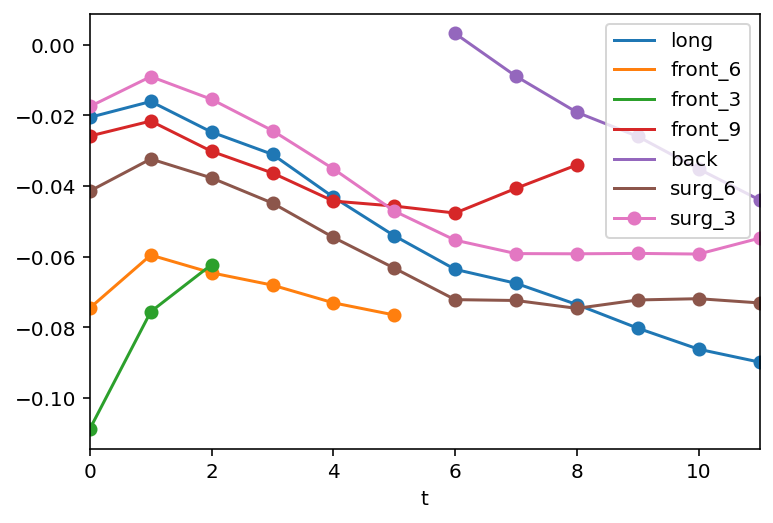

In [6]:
bl = pd.read_csv('logs/baseline7/test_metrics.csv', index_col=0).mae

short = pd.read_csv('logs/catgc_clip_3_t_12_6/test_metrics.csv', index_col=0)
short3 = pd.read_csv('logs/front_3/test_metrics.csv', index_col=0).mae - bl.head(3)
short9 = (pd.read_csv('logs/front_9/test_metrics.csv', index_col=0).mae - bl.head(9)).to_frame('front_9')

long = pd.read_csv('logs/replace-0-feat_v2/test_metrics.csv', index_col=0).mae -bl

surg = pd.read_csv('logs/surgery_t12_6/test_metrics.csv', index_col=0).mae - bl
surg3 = pd.read_csv('logs/surgery_front_3/test_metrics.csv', index_col=0).mae - bl

back =  pd.read_csv('logs/catgc_clip_3_offset__7_12/test_metrics.csv', index_col=0).mae 
back.index = back.index+6 

back =  pd.read_csv('logs/catgc_clip_3_offset__7_12/test_metrics.csv', index_col=0).mae

back.index = back.index+6 

#pd.read_csv('logs/catgc_clip_3_offset__7_12/test_metrics.csv', index_col=0)

ax = long.to_frame('long').plot(style='-o')
(short.mae - bl.head(6)).to_frame('front_6').plot(ax=ax, style='-o')
short3.to_frame('front_3').plot(ax=ax, style='-o')
short9.plot(ax=ax, style='-o')
(back- bl.tail(6)).to_frame('back').plot(ax=ax, style='-o')
surg.to_frame('surg_6').plot(ax=ax, style='-o')
surg3.to_frame('surg_3').plot(ax=ax, style='-o')

In [13]:
long = pd.read_csv('logs/replace-0-feat_v2/test_metrics.csv', index_col=0).tail(6)
catted = pd.concat([pd.read_csv('logs/catgc_clip_3_t_12_6/test_metrics.csv', index_col=0), long])
catted.mean()

mae     2.981355
mape    0.081183
rmse    5.935189
dtype: float64

In [5]:
tab.loc['surgery_front_3']

train_loss            2.80489
train_mape           0.074919
train_rmse            5.60668
valid_loss            2.72805
valid_mape           0.074973
valid_rmse            5.27131
best_epoch                 32
min_train_loss         2.7365
date              12-06-15:24
es20_score            2.72805
es20_i                     52
es10_score            2.72805
es10_i                     42
test_mae              3.01317
test_mape           0.0818051
test_rmse             5.97758
test_loss                 NaN
Name: surgery_front_3, dtype: object

In [ ]:
back

In [4]:
summaries = {os.path.basename(c): summary(c) for c in glob('logs/*')}
tab = pd.DataFrame.from_dict(summaries, orient='index')
nc = get_num_cols(tab)
tab.to_msgpack('latest_metrics.mp')
tab.round({c: 4 for c in nc})[nc.tolist() + ['date']].sort_values('test_mae').head(100)

/home/shleifer/.conda/envs/nb/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  after removing the cwd from sys.path.


,train_loss,train_mape,train_rmse,valid_loss,valid_mape,valid_rmse,best_epoch,min_train_loss,es20_score,es20_i,es10_score,es10_i,test_mae,test_mape,test_rmse,test_loss,date
front_1,2.0282,0.0457,3.4831,1.9568,0.0448,3.3350,97.0,2.0276,1.9568,99,1.9568,99,2.1357,0.0503,3.7082,NaN,12-06-14:54
front_3,2.2550,0.0533,4.1214,2.1794,0.0528,3.9365,98.0,2.2539,2.1794,99,2.1794,99,2.3972,0.0592,4.3965,NaN,12-06-13:23
catgc_clip_3_t_12_6,2.4717,0.0618,4.7332,2.4084,0.0624,4.5413,76.0,2.4690,2.4084,78,2.4152,65,2.6597,0.0689,5.0939,NaN,12-04-22:29
catgc_nhid40_seq_len_6,2.4961,0.0625,4.7963,2.4941,0.0646,4.7549,75.0,2.4822,2.4941,95,2.5025,64,2.6731,0.0689,5.1211,NaN,12-04-12:56
front_9,2.6732,0.0696,5.2682,2.5941,0.0709,4.9901,38.0,2.6623,2.5941,41,2.5941,41,2.8758,0.0769,5.6416,NaN,12-06-13:56
surgery_t12_6,2.6984,0.0711,5.3523,2.6909,0.0746,5.2014,29.0,2.6486,2.6909,49,2.6909,39,2.9952,0.0817,5.9641,2.8771,12-04-23:25
catgc_clip_3_lrd_97_nhid40_v2,2.7168,0.0720,5.4021,2.7114,0.0752,5.2668,67.0,2.6861,2.7114,87,2.7386,39,2.9981,0.0817,5.9847,NaN,12-04-17:29
replace-0-feat_v2,2.7361,0.0727,5.4589,2.7203,0.0752,5.2630,55.0,2.7040,2.7203,75,2.7282,45,3.0002,0.0818,5.9746,NaN,12-05-23:47
skip_channels_400,2.7581,0.0734,5.5062,2.7234,0.0757,5.2921,49.0,2.7171,2.7234,69,2.7234,59,3.0020,0.0822,5.9804,NaN,12-05-16:04
catgc_nhid40_lrd_0.99,2.8849,0.0777,5.7723,2.7371,0.0763,5.2582,27.0,2.8675,2.7371,31,2.7371,31,3.0040,0.0817,5.9994,NaN,12-02-11:24


In [ ]:
args = pickle_load('baseline_args.pkl')

data = util.load_dataset(args.data, args.batch_size, args.batch_size, args.batch_size, n_obs=args.n_obs)

data['scaler'].mean, data['scaler'].std

ax = loss_curve('dow_raw').plot(figsize=(6,6))
loss_curve('catgc_clip_3_lrd_97_nhid40').add_prefix('base_').plot(figsize=(6,6), ax=ax)





t712 = pd.read_csv('logs/catgc_clip_3_offset__7_12/test_metrics.csv', index_col=0)
t712

pd.read_csv('logs/catgc_clip_3_lrd_97_nhid40/test_metrics.csv', index_col=0).tail(6)

pickle_load('logs/skip_channels_400/metadata.pkl')

tab.loc['dow_raw']

In [68]:
tab.loc['bs_512_fixed_lr']

train_loss             2.8607
train_mape          0.0765048
train_rmse            5.68195
valid_loss            2.79065
valid_mape          0.0768377
valid_rmse            5.61896
best_epoch                 98
min_train_loss        2.85301
date              11-28-19:38
es20_score            2.79065
es20_i                     99
es10_score            2.83846
es10_i                     50
test_mae              3.08225
test_mape           0.0848333
test_rmse              6.1115
test_loss                 NaN
Name: bs_512_fixed_lr, dtype: object

In [69]:
tab.loc['baseline7']

train_loss             2.7886
train_mape             0.0743
train_rmse             5.5527
valid_loss             2.7351
valid_mape              0.075
valid_rmse             5.2642
best_epoch                 70
min_train_loss         2.7523
date              11-29-02:42
es20_score             2.7351
es20_i                     90
es10_score             2.7484
es10_i                     55
test_mae              3.05442
test_mape           0.0823333
test_rmse             6.06842
test_loss                 NaN
Name: baseline7, dtype: object

27


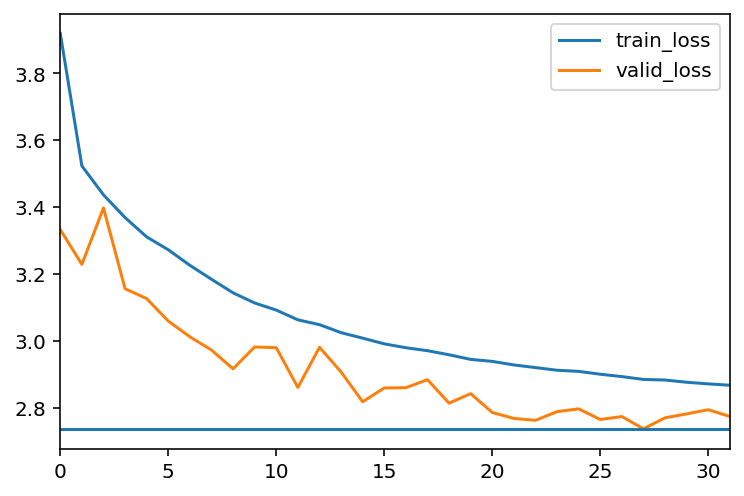

In [3]:
d = loss_curve('catgc_nhid40_lrd_0.99').head(35)
ax = d.plot()
plt.axhline(d.valid_loss.min())
#plt.axvline(14)
print(d.valid_loss.idxmin())

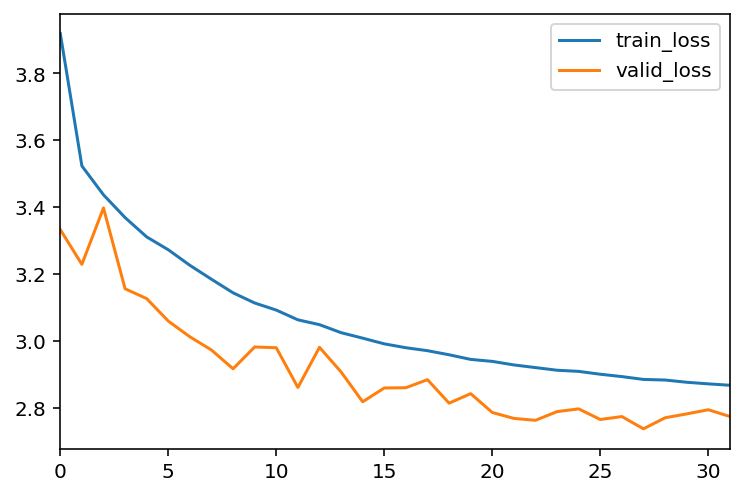

In [4]:
loss_curve('catgc_nhid40_lrd_0.99').plot()

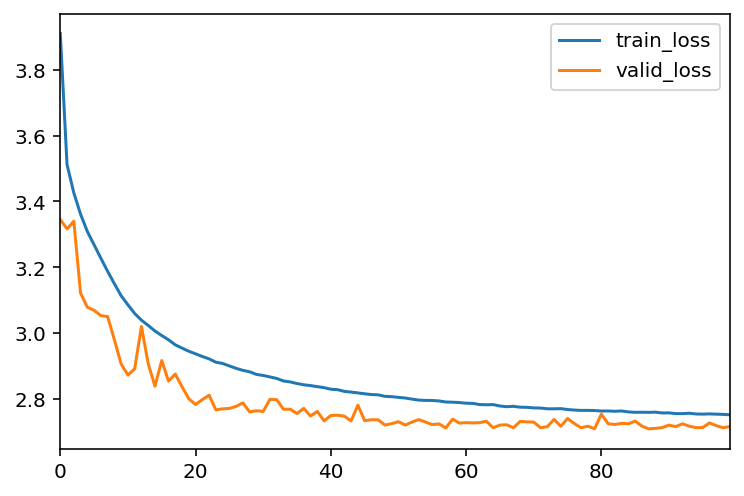

In [5]:
loss_curve('catgc_nhid40_lrd_0.95').plot()

In [37]:
#pd.read_csv('logs/add_gc_baseline/preds.csv').min()

In [44]:
ls logs/catgc_clip_2_lrd_97

args.pkl  best_model.pth  metadata.pkl  metrics.csv  test_metrics.csv


In [59]:
mv logs/catgc_clip_2_lrd_97 logs/catgc_clip_2_lrd_97_nhid40

In [90]:
pd.read_csv('logs/catgc_nhid40_lrd_0.99_v2/metrics.csv').pipe(subset, ['loss']).plot()

In [66]:
tab[tab.valid_loss < 2.75].shap

(21, 18)

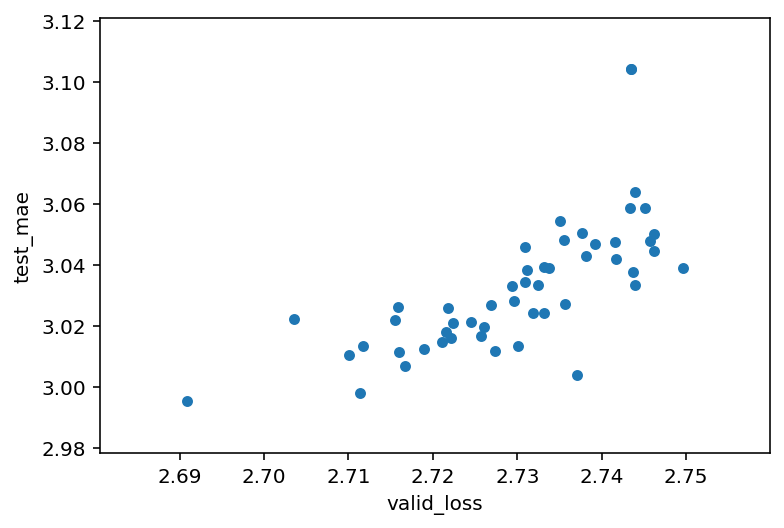

In [39]:
tab[(tab.valid_loss < 2.75) & (tab.test_mae < 3.2) & (tab.valid_loss > 2.55)].plot.scatter(x='valid_loss', y='test_mae')

In [18]:
s6 = pd.read_csv('logs/catgc_nhid40_seq_len_6/test_metrics.csv', index_col=0)

In [19]:
s12 = pd.read_csv('logs/catgc_clip_4_lrd_97_nhid40/test_metrics.csv', index_col=0)

In [26]:
improvement = s12.head(6) - s6
improvement

,mae,mape,rmse
t,,,
0,0.037871,0.001241,0.090233
1,0.025943,0.000731,0.076548
2,0.027989,0.000834,0.071236
3,0.027029,0.000744,0.074011
4,0.019894,0.000449,0.067328
5,0.011825,0.000092,0.056449


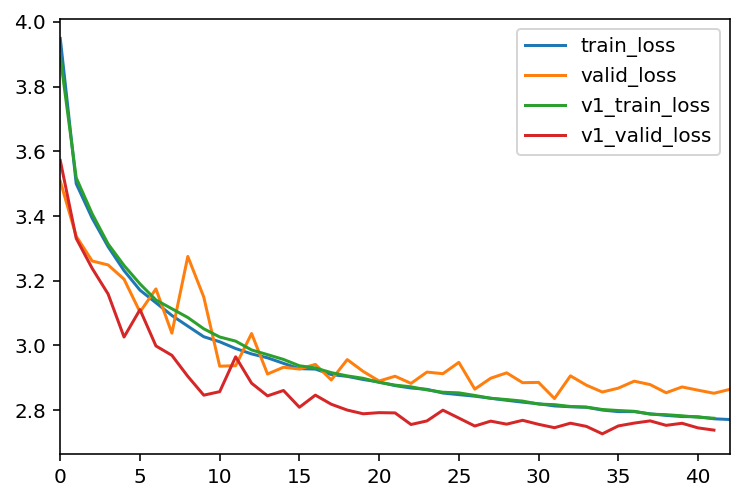

In [11]:
ax = loss_curve('logs/catgc_clip_3_lrd_97_nhid40_v2/').plot()
loss_curve('logs/catgc_clip_3_lrd_97_nhid40/').head(42).add_prefix('v1_').plot(ax=ax)

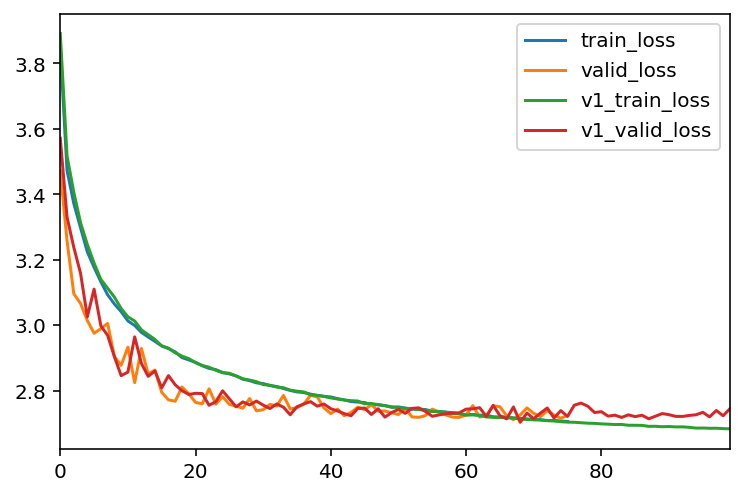

In [16]:
ax = loss_curve('logs/catgc_clip_3_lrd_97_nhid40_v2/').plot()
loss_curve('logs/catgc_clip_3_lrd_97_nhid40/').add_prefix('v1_').plot(ax=ax)

In [20]:
seq_length = 12
x_offsets = np.sort(np.concatenate((np.arange(-(seq_length - 1), 1, 1),)))

y_offsets = np.sort(np.arange(1, (seq_length + 1), 1))

In [22]:
x_offsets

array([-11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0])

In [21]:
y_offsets

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [31]:
pickle_load('logs/catgc_clip_3_lrd_97_nhid40/metadata.pkl')

{'date': '2019-12-03-18:17:15',
 'branch': 'master',
 'runtime': 84.40258767604828}

In [31]:
val_ts.head()[[:6]]

t,0,1,2,3,4,5,6,7,8,9,10,11
epoch,,,,,,,,,,,,
0,2.238773,2.540319,2.766938,2.960691,3.133506,3.290497,12.075896,11.846109,11.134290,11.792063,10.730303,11.021757
2,2.062324,2.313159,2.487053,2.628664,2.741528,2.839528,2.922224,3.001096,3.071752,3.133916,3.196247,3.261839
3,2.065176,2.310613,2.479302,2.612068,2.726832,2.824262,2.912179,2.988843,3.061409,3.125404,3.183621,3.251594
4,2.057276,2.303777,2.470208,2.602266,2.723184,2.817395,2.905609,2.985737,3.052621,3.113910,3.170520,3.229811
5,2.061854,2.305904,2.478938,2.619848,2.737687,2.837034,2.910292,2.987834,3.060872,3.122151,3.178870,3.236028


In [32]:
tm6 = pd.read_csv('logs/catgc_clip_3_t_12_6/test_metrics.csv', index_col=0)

In [34]:
pd.read_csv('logs/surgery_t12_6/test_metrics.csv', index_col=0).head(6)

,mae,mape,rmse
t,,,
0,2.192615,0.052006,3.775220
1,2.473688,0.061570,4.555334
2,2.660313,0.068608,5.084322
3,2.808197,0.074444,5.494185
4,2.930484,0.079439,5.825542
5,3.034795,0.083473,6.112247


In [35]:
tm6

,mae,mape,rmse
t,,,
0,2.159525,0.051048,3.716178
1,2.446493,0.060767,4.502765
2,2.633458,0.067655,5.031873
3,2.784979,0.073334,5.451159
4,2.911976,0.078185,5.788602
5,3.021536,0.082300,6.072630


In [13]:
val_met = pd.read_msgpack('logs/surgery_t12_6/val_ts_metrics.mp')

In [16]:
val_met.groupby('epoch').mean().head()

,mae,mape,rmse
epoch,,,
0,7.127595,0.189563,9.652049
2,2.804944,0.077025,5.677625
3,2.795109,0.078577,5.699111
4,2.786026,0.079258,5.681844
5,2.794776,0.081313,5.701449


In [22]:
val_ts = val_met.set_index('epoch', append=True).mae.unstack('t')

In [25]:
val_ts.mean(1).head(6).tail(5)

epoch
2    2.804944
3    2.795109
4    2.786026
5    2.794776
6    2.833704
dtype: float64

In [26]:
pd.read_csv('logs/surgery_t12_6/metrics.csv', index_col=0).valid_loss.head()

0    2.763850
1    2.759017
2    2.748445
3    2.756769
4    2.793560
Name: valid_loss, dtype: float64

In [17]:
summary('logs/surgery_t12_6')

train_loss            2.69839
train_mape           0.071131
train_rmse            5.35232
valid_loss            2.69088
valid_mape           0.074577
valid_rmse            5.20142
test_loss             2.87712
test_mape            0.078454
test_rmse             5.58229
best_epoch                 29
min_train_loss        2.64864
date              12-04-23:25
es20_score            2.69088
es20_i                     49
es10_score            2.69088
es10_i                     39
test_mae              2.99524
test_mape           0.0817155
test_rmse             5.96411
dtype: object

,train_loss,train_mape,train_rmse,valid_loss,valid_mape,valid_rmse,test_loss,test_mape,test_rmse
0,3.015238,0.081299,5.905416,2.763850,0.075851,5.301300,2.964000,0.079803,5.681182
1,2.878663,0.077395,5.736143,2.759017,0.077593,5.319852,2.939792,0.081759,5.695280
2,2.855020,0.076603,5.700277,2.748445,0.078143,5.301726,2.925142,0.081511,5.633650
3,2.845773,0.076285,5.686201,2.756769,0.080107,5.304424,2.925313,0.083246,5.630223
4,2.833188,0.075857,5.659127,2.793560,0.079724,5.347400,2.973964,0.082975,5.694450
5,2.822660,0.075456,5.635772,2.733875,0.075189,5.243294,2.912289,0.078403,5.588139
6,2.812965,0.075122,5.613942,2.744125,0.078774,5.265176,2.933120,0.082986,5.643149
7,2.806497,0.074926,5.601945,2.721878,0.075483,5.199852,2.905680,0.078748,5.550199
8,2.797231,0.074550,5.580240,2.769696,0.079436,5.343644,2.923900,0.081994,5.638175
9,2.793452,0.074429,5.572321,2.739749,0.078516,5.277908,2.911309,0.082028,5.628092


In [28]:
pickle_load('logs/catgc_nhid40_lrd_0.99_v2/metadata.pkl')

{'date': '2019-12-03-22:27:27',
 'branch': 'cyclical-lr',
 'runtime': 90.92834924062093}

In [30]:
pickle_load('logs/catgc_clip_4_lrd_97_nhid40/metadata.pkl')

{'date': '2019-12-03-19:46:37',
 'branch': 'master',
 'runtime': 84.69123902320862}

In [31]:
pickle_load('logs/catgc_clip_3_lrd_97_nhid40/metadata.pkl')

{'date': '2019-12-03-18:17:15',
 'branch': 'master',
 'runtime': 84.40258767604828}

In [32]:
pickle_load('logs/catgc_nhid40_seq_len_6/metadata.pkl')

{'date': '2019-12-04-13:12:43',
 'branch': 'master',
 'runtime': 78.89185889164607}

In [80]:
mv logs/no_graph_convv2   logs/no_graph_conv2

In [79]:
ls logs/apt_only_20_fixed

best_model.pth  metrics.csv  preds.csv  test_metrics.csv


In [71]:
!mv logs/apt_only/ logs/no_graph_conv3

In [83]:
a = pickle_load('logs/apt_only_aptsize256/args.pkl').__dict__
b = pickle_load('logs/no_graph_conv2/args.pkl').__dict__
#c = pickle_load('logs/apt_only_20_fixed/args.pkl').__dict__
baseline = pickle_load('logs/cheaper-metric-fixed/args.pkl').__dict__
#aptinit = pickle_load('logs/aptinit/args.pkl').__dict__

In [105]:
def r_args(strang):
    return pickle_load(f'logs/{strang}/args.pkl').__dict__

In [108]:
dct_compare(r_args('logs_0.001/'), r_args('baseline_lr_decay/'))

{}

In [85]:
mv logs/no_graph_conv2/ logs/no_add_apt_adj

In [76]:
!mv logs/apt_only_aptsize20 logs/no_graph_conv4

In [97]:
dct_compare(r_args('cat_feat_early_gc_256_rand'), r_args('cat_feat_early'))

{'apt_size': (256, 10)}

In [84]:
dct_compare(baseline, b)

{'apt_size': (None, 10), 'addaptadj': (True, False)}

In [87]:
dct_compare(baseline, a)

{'apt_size': (None, 256), 'aptonly': (False, True)}

In [67]:
dct_compare(pickle_load('logs/bs_512_fixed_lr/args.pkl').__dict__, baseline)

{'learning_rate': (0.004, 0.001), 'batch_size': (512, 64)}

In [74]:
dct_compare(baseline, c)

{'apt_size': (None, '20'),
 'addaptadj': (True, False),
 'aptonly': (False, True)}

In [75]:
dct_compare(baseline, a)

{'apt_size': (None, 256), 'aptonly': (False, True)}

In [104]:
def dct_compare(a,b, ignore_keys=('save')):
    allk = set(a.keys()).union(b)
    res = {}
    for k in allk:
        if k in ignore_keys: continue
        av,bv = a.get(k, None), b.get(k, None)
        if av != bv: res[k] = (av, bv)
    return res

In [61]:
dct_compare(a,b)

{'apt_size': (256, None), 'addaptadj': (True, False)}

In [62]:
dct_compare(a,c)

{'apt_size': (256, '20'), 'addaptadj': (True, False)}

In [6]:
cfe = pd.read_csv('logs/cat_feat_early/metrics.csv', index_col=0)
no_apt = pd.read_csv('logs/no_apt_adj/metrics.csv', index_col=0)

In [11]:
pd.read_csv('logs/cat_feat_early/test_metrics.csv').mean()

t       5.500000
mae     3.078333
mape    0.086167
rmse    6.108000
dtype: float64

In [12]:

pd.read_csv('logs/no_apt_adj/test_metrics.csv').mean()

t       5.500000
mae     3.078333
mape    0.086167
rmse    6.108000
dtype: float64

In [7]:
cfe.min()

train_loss    2.7557
train_mape    0.0730
train_rmse    5.4684
valid_loss    2.7437
valid_mape    0.0742
valid_rmse    5.2934
dtype: float64

In [9]:
no_apt.min()

train_loss    2.8266
train_mape    0.0752
train_rmse    5.6161
valid_loss    2.7791
valid_mape    0.0756
valid_rmse    5.3568
dtype: float64

In [20]:
pd.read_csv('bs_512_fixed_lr/metrics.csv', index_col=0).min()

train_loss    2.853006
train_mape    0.076463
train_rmse    5.673001
valid_loss    2.790653
valid_mape    0.073916
valid_rmse    5.586741
dtype: float64

In [35]:
summary(d)

train_loss    2.806
train_mape    0.075
train_rmse    5.567
valid_loss    2.744
valid_mape    0.075
valid_rmse    5.286
test_mae      3.064
test_mape     0.082
test_rmse     6.090
dtype: float64

In [36]:
summary('bs_512_fixed_lr/')

train_loss    2.861
train_mape    0.077
train_rmse    5.682
valid_loss    2.791
valid_mape    0.077
valid_rmse    5.619
test_mae      3.082
test_mape     0.085
test_rmse     6.111
dtype: float64

In [19]:
pd.read_csv('smart-trunc/test_metrics.csv', index_col=0)

,mae,mape,rmse
t,,,
0,"tensor(9.0320, device='cuda:0')","tensor(inf, device='cuda:0')","tensor(20.9467, device='cuda:0')"
1,"tensor(9.3068, device='cuda:0')","tensor(inf, device='cuda:0')","tensor(21.1640, device='cuda:0')"
2,"tensor(9.4969, device='cuda:0')","tensor(inf, device='cuda:0')","tensor(21.3153, device='cuda:0')"
3,"tensor(9.6529, device='cuda:0')","tensor(inf, device='cuda:0')","tensor(21.4574, device='cuda:0')"
4,"tensor(9.7829, device='cuda:0')","tensor(inf, device='cuda:0')","tensor(21.5728, device='cuda:0')"
5,"tensor(9.8915, device='cuda:0')","tensor(inf, device='cuda:0')","tensor(21.6725, device='cuda:0')"
6,"tensor(9.9942, device='cuda:0')","tensor(inf, device='cuda:0')","tensor(21.7760, device='cuda:0')"
7,"tensor(10.0769, device='cuda:0')","tensor(inf, device='cuda:0')","tensor(21.8443, device='cuda:0')"
8,"tensor(10.1518, device='cuda:0')","tensor(inf, device='cuda:0')","tensor(21.9093, device='cuda:0')"


In [18]:
pd.read_csv('bs_512_fixed_lr/test_metrics.csv', index_col=0)

,mae,mape,rmse
t,,,
0,2.266,0.056,3.912
1,2.542,0.066,4.692
2,2.730,0.073,5.208
3,2.877,0.078,5.610
4,3.000,0.083,5.935
5,3.106,0.086,6.213
6,3.205,0.090,6.464
7,3.299,0.092,6.696
8,3.383,0.095,6.903


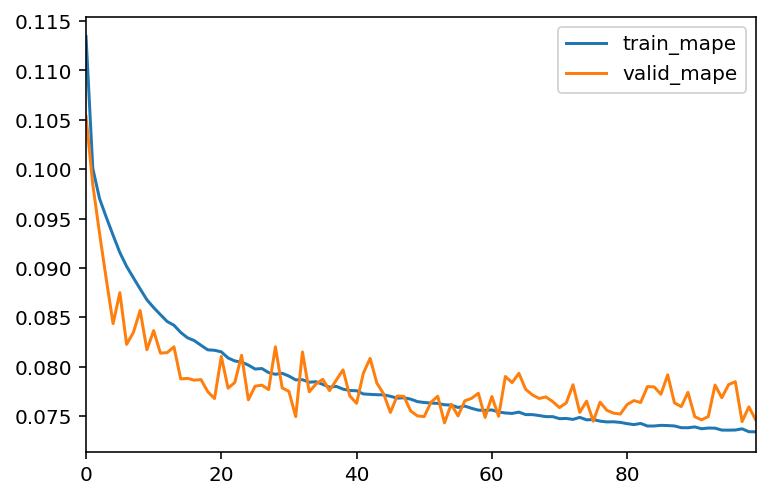

In [17]:
cheap_met = pd.read_csv('smart-trunc/metrics.csv', index_col=0)
cheap_met.pipe(subset, ['mape']).plot()

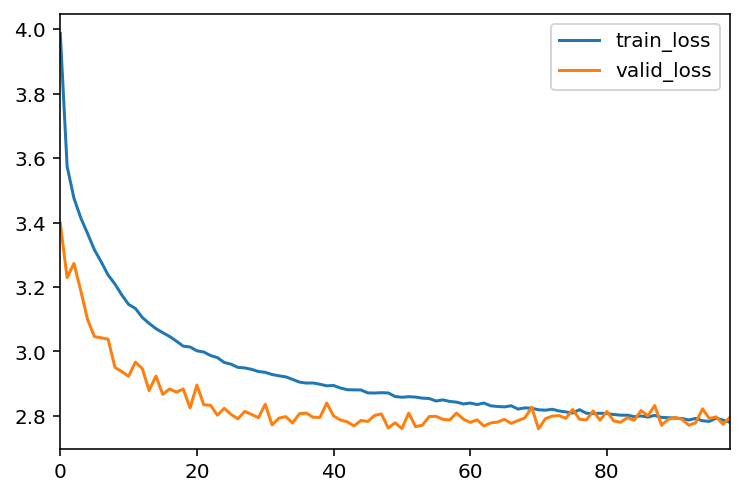

In [ ]:
ls 